In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import xml.etree.ElementTree as ET
from lxml import etree

In [3]:
run -im djd.main -- --dbname=dj_lisa --r

For remote access to work, make sure to first open an SSH tunnel with MySQL
port forwarding. Run the `djdtunnel` script in a separate terminal, with
optional `--user` argument if your local and remote user names differ.
Or, open the tunnel manually with:
  ssh -NL 3306:huxley.neuro.bzm:3306 -p 1021 USERNAME@tunnel.bio.lmu.de
Connecting execute@localhost:3306
Connected to database 'dj_lisa' as 'execute@10.153.172.3'
For remote file access to work, make sure to first mount the filesystem at tunnel.bio.lmu.de:1021 via SSH


In [4]:
run -i /gpfs01/berens/user/lschmors/Code/dLGN_project/djd/djd/signal.py

In [5]:
run -i /gpfs01/berens/user/lschmors/Code/dLGN_project/djd/djd/util.py

In [6]:
key = {'m': 'Ntsr1Cre_2019_0007', 's':1, 'e':6} # one example experiment with hmov stimulus

In [15]:
parentkey = key

### Get trials

In [16]:
trials = (Stimulus.Hmov() * Stimulus.MovieCond() * Stimulus.Trial() & parentkey).fetch(as_dict=True)
trials.sort(key=lambda i: i['trial_id'])  # alternatives: sorted (for new list), and itemgetter

In [17]:
trial = trials[6]
trial

{'m': 'Ntsr1Cre_2019_0007',
 's': 1,
 'e': 6,
 'hm_version': 3,
 'hm_seq_num': 1,
 'stim_id': 0,
 'trial_id': 6,
 'hm_width_pix': 424,
 'hm_height_pix': 264,
 'hm_width_deg': 106.0,
 'hm_height_deg': 66.0,
 'movie_name': 'hmovTest',
 'movie_form': 'Rectangle',
 'movie_orientation': 90.0,
 'movie_contrast': 1.0,
 'movie_width': 106.0,
 'movie_height': 66.0,
 'movie_x_position': 45.0,
 'movie_y_position': 0.0,
 'trial_on_time': 722.9245,
 'trial_off_time': 763.0350999999999}

### Get scene info

In [18]:
# Get scenes and sort by scene position
scenes = (Hmov.RandSeqPars() & trial).fetch(as_dict=True)
scenes.sort(key=lambda i: i['hm_scene_pos'])  # alternatives: sorted (for new list), and itemgetter

# Get hollymov version pars
(fps, scene_dur) = (Hmov.VersionPars() & trial).fetch1('hm_fps', 'hm_scene_dur_sec')

# Calculate scene times
trial_ton = trial['trial_on_time']
fp_scene = fps * scene_dur # unique frames per scene
fps_monitor = 60 # Expo monitor frame rate (Hz) # TODO: find non-hard coded value elsewhere
n_scenes = len(scenes)

# Calc frame ids and corresponding frame nums - every frame was presented twice, given hmov fps=30 and fps_monitor=60
frame_ids = np.repeat(np.arange(fp_scene), fps_monitor/fps)
frame_nums = np.arange(len(frame_ids))

# get trial on and off times recorded by expo
ton_rec = trial['trial_on_time']
toff_rec = trial['trial_off_time']

In [19]:
dur_test = 40#scene_dur*n_scenes_test
dur_train = 180#scene_dur*n_scenes_train

### Get photodiode rise and fall times

In [7]:
chan = 'photodiode'
nsxfname = key2datafname(key, filetype='.ns3', force_exist=True)
print(nsxfname)
# retrieve info from nsx file:
f = expio.nsx.File(nsxfname)
ttl = f.get_chanV(chan)
t0, tres = f.t0, f.fileheader.tres # inital offset and time resolution, in us
f.close()

/gpfs01/berens/user/lschmors/mudata/exp/Ntsr1Cre_2019_0007/s01/Ntsr1Cre_2019_0007_s01_e06.ns3


In [8]:
print(t0)
print(tres)

0.0
500.0


In [9]:
ttl.shape

(3851626,)

(-192581.25, 4044206.25, -0.11482589190343942, 4.4154942472609635)

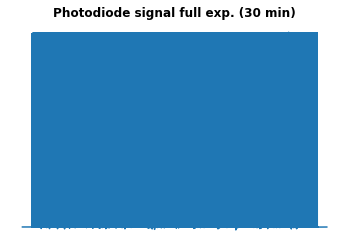

In [53]:
plt.plot(ttl)
plt.title('Photodiode signal full exp. (30 min)', fontweight='bold')
plt.axis('off')

(-49.95, 1048.95, -0.05286568803979613, 4.390003662221137)

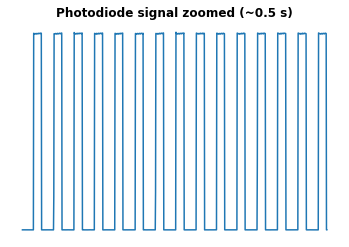

In [69]:
plt.plot(ttl[200000:201000])
plt.title('Photodiode signal zoomed (~0.5 s)', fontweight='bold')
plt.axis('off')

In [25]:
rise, fall = get_nsx_risefalltimes({'m':trial['m'], 's':trial['s'], 'e':trial['e']}, chan='photodiode')
sortedrisefall = np.sort(np.hstack([rise, fall]))

/gpfs01/berens/user/lschmors/mudata/exp/Ntsr1Cre_2019_0007/s01/Ntsr1Cre_2019_0007_s01_e06.ns3


In [26]:
sortedrisefall

array([  61.642 ,   61.6565,   61.6765, ..., 1865.1795, 1865.1995,
       1865.2125])

In [38]:
sortedrisefalldiff = np.diff(sortedrisefall)
sortedrisefalldiff[:10]

array([0.0145, 0.02  , 0.013 , 0.0205, 0.013 , 0.0205, 0.013 , 0.0205,
       0.013 , 0.02  ])

Text(0, 0.5, 'Difference betw. frame switch (s)')

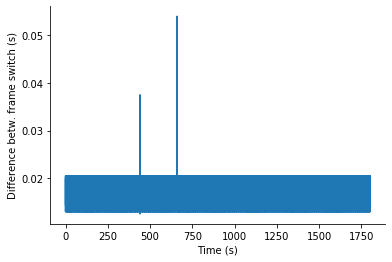

In [84]:
tv = np.linspace(0,1800, sortedrisefalldiff.shape[0])
plt.plot(tv,sortedrisefalldiff)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (s)')
plt.ylabel('Difference betw. frame switch (s)')

In [29]:
np.unique(sortedrisefalldiff)

array([0.0125, 0.013 , 0.013 , 0.013 , 0.013 , 0.013 , 0.013 , 0.013 ,
       0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0145,
       0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.0205,
       0.0205, 0.0205, 0.0205, 0.0205, 0.0205, 0.0205, 0.0375, 0.054 ])

Instead of 0.02 between fall and rise, it should be ~ 0.0166

### Correct photodiode signal

I want to keep the rise times fixed and change the fall times, so that the difference between rise and fall is approx. equal.

Therefore, I add a correction factor to the fall times:

In [37]:
# correction factor
cf = np.mean(np.abs(np.diff(sortedrisefalldiff)/2)) # Correction factor (cf)): the mean of (0.013-0.02)/2
cf

0.0034762796533269642

In [40]:
fallcf = fall + cf
risefallcf = np.sort(np.hstack([rise, fallcf]))

In [41]:
np.diff(risefallcf)

array([0.01797628, 0.01652372, 0.01647628, ..., 0.01697628, 0.01652372,
       0.01647628])

Text(0, 0.5, 'Corrected difference(s)')

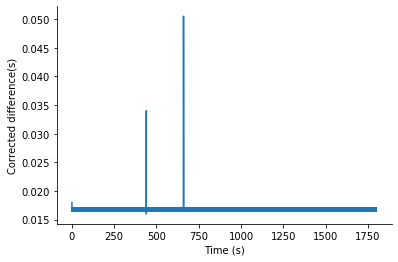

In [83]:
plt.plot(tv,np.diff(risefallcf))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (s)')
plt.ylabel('Corrected difference(s)')

Text(0, 0.5, '#occurrences')

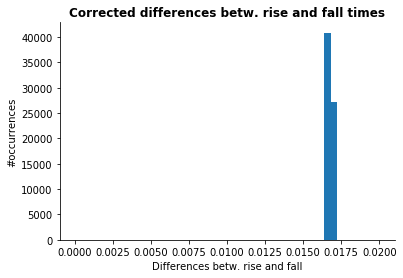

In [81]:
plt.hist(np.diff(risefallcf[40000:]), bins=50, range=(0.0,0.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Corrected differences betw. rise and fall times', fontweight='bold')
plt.xlabel('Differences betw. rise and fall')
plt.ylabel('#occurrences')

# Digital word signal

In [85]:
dwordts = get_nev_times(key)

In [86]:
dwordts.shape

(115200,)

In [87]:
dwordts[0]

1.4861666666666666

In [105]:
dwordts[:10]

array([1.48616667, 1.50276667, 1.51946667, 1.53616667, 1.55286667,
       1.56956667, 1.58626667, 1.60293333, 1.61966667, 1.6364    ])

In [106]:
np.diff(dwordts)

array([0.0166    , 0.0167    , 0.0167    , ..., 0.01666667, 0.01673333,
       0.0167    ])

Text(0.5, 1.0, 'Time delay in send out dwords')

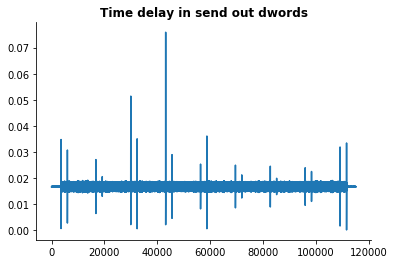

In [101]:
plt.plot(np.diff(dwordts))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Time delay in send out dwords', fontweight='bold')

In [95]:
idx_stop = np.searchsorted(dwordts, sortedrisefall[-1])-1
idx_start = np.searchsorted(dwordts, sortedrisefall[0])-1 # -1 bc. measured photodiode signal comes after send out frame (aka dword)
dwordts_hmov = dwordts[idx_start:idx_stop+1]

Text(0.5, 1.0, 'Time delay in case of frame drop')

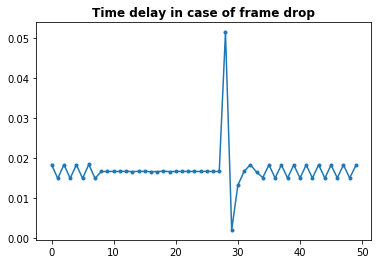

In [102]:
plt.plot(np.diff(dwordts_hmov)[26370:26420], marker='.')
#plt.axis('off')
plt.title('Time delay in case of frame drop', fontweight='bold')

Text(0.5, 0, 'Time (s)')

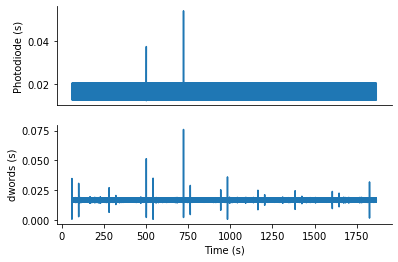

In [100]:
fig, axs = plt.subplots(2,1)

axs[0].plot(np.diff(sortedrisefall))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_ylabel('Photodiode (s)')
axs[0].set_xticks([])

axs[1].plot(dwordts_hmov[:-1], np.diff(dwordts_hmov))
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_ylabel('dwords (s)')
axs[1].set_xlabel('Time (s)')